In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from grasp_baseline.inference import GraspDetector
from grasp_baseline.utils import visualize

In [2]:
#detector = GraspDetector(yolo_cfg='') # Use selective search
#detector = GraspDetector(yolo_cfg='./YOLO3-4-Py/cfg/yolov3.cfg', yolo_weight='./YOLO3-4-Py/weights/yolov3.weights', yolo_data='./YOLO3-4-Py/cfg/coco.data') 
detector = GraspDetector() 

In [3]:
img = cv2.imread('./example_imgs/rgb1.jpg', cv2.IMREAD_COLOR)[...,::-1]
depth = cv2.imread('./example_imgs/depth1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(cv2.imread('./example_imgs/rgb2.jpg', cv2.IMREAD_COLOR), (640,480), interpolation=cv2.INTER_AREA)[...,::-1]
depth2 = cv2.resize(cv2.imread('./example_imgs/depth2.jpg', cv2.IMREAD_GRAYSCALE), (640,480), interpolation=cv2.INTER_AREA)

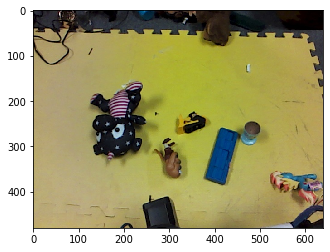

In [4]:
plt.imshow(img)
plt.show()

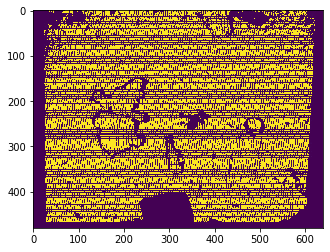

In [5]:
plt.imshow(depth)
plt.show()

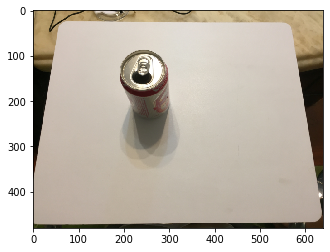

In [6]:
plt.imshow(img2)
plt.show()

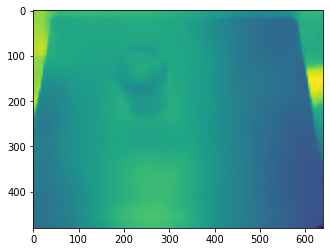

In [7]:
plt.imshow(depth2)
plt.show()

In [8]:
bboxes, degs, confs, centers, cats, scores = detector.detect([img,img2], [depth,depth2])

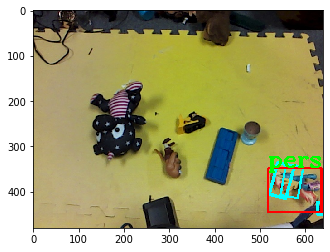

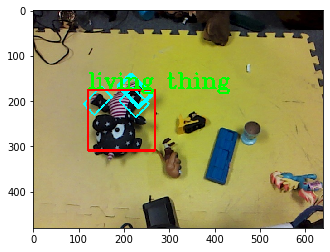

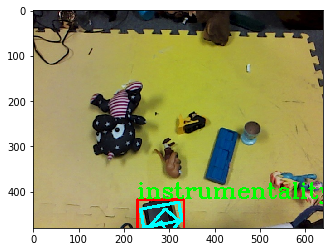

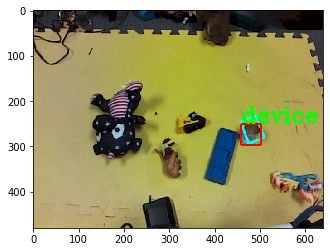

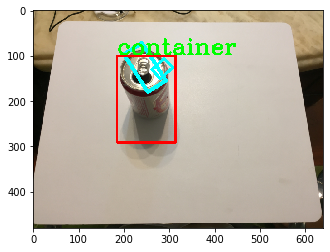

In [9]:
visualize([img,img2], bboxes, confs, centers, cats)